In [1]:
import keras

Using TensorFlow backend.


In [21]:
import numpy as np
from keras.layers import Dense, Conv2D, AvgPool2D, Flatten, UpSampling2D, BatchNormalization, Concatenate, Input
from keras import Model

In [3]:
from keras.optimizers import Adam
from keras.datasets import mnist
import matplotlib.pyplot as plt
import keras.backend as K

In [29]:
from keras.losses import binary_crossentropy

In [96]:
(mnist_train, mnist_train_y), (mnist_test, mnist_test_y) = mnist.load_data()

In [97]:
mnist_train = (mnist_train - 128.0)/128.0

In [98]:
mnist_test = (mnist_test - 128.0)/128.0

In [99]:
mnist_train.shape

(60000, 28, 28)

In [100]:
mnist_train.min()

-1.0

In [101]:
mnist_train = np.expand_dims(mnist_train, 3)
mnist_test = np.expand_dims(mnist_test, 3)

In [117]:
mnist_train_y_3 = np.array(mnist_train_y == 3)
mnist_train_3 = np.array(mnist_train[mnist_train_y_3])
mnist_train_3.shape

(6131, 28, 28, 1)

In [110]:
def createGenerator(convDepth, numConvs):
    latent_shape = (7,7,1)
    z = Input(shape = latent_shape)
    t = Conv2D(convDepth, (3,3), padding="same", activation="relu")(z)
    t = Concatenate()([z,t])
    for _ in range(numConvs-1):
        q = Conv2D(convDepth, (3,3), padding="same", activation="relu")(t)
        t = Concatenate()([t,q])
    t = UpSampling2D()(t)
    for _ in range(numConvs):
        q = Conv2D(convDepth, (3,3), padding="same", activation="relu")(t)
        t = Concatenate()([t,q])
    t = UpSampling2D()(t)
    for _ in range(numConvs):
        q = Conv2D(convDepth, (3,3), padding="same", activation="relu")(t)
        t = Concatenate()([t,q])
    res = Conv2D(1, (1,1), padding="same", activation="tanh")(t)
    generator = Model(z, res)
    return generator

In [104]:
def createDiscriminator(convDepth):
    z = Input(shape = (28,28,1))
    t = Conv2D(convDepth, (3,3), padding = "same", activation="relu")(z)
    t = Concatenate()([z, t])
    t = AvgPool2D()(t)
    q = Conv2D(convDepth, (3,3), padding = "same", activation = "relu")(t)
    t = Concatenate()([t, q])
    t = AvgPool2D()(t)
    q = Conv2D(convDepth, (3,3), padding = "same", activation = "relu")(t)
    t = Concatenate()([t, q])
    t = AvgPool2D((7, 7))(t)
    t = Flatten()(t)
    t = Dense(1, activation="sigmoid")(t)

    discriminator = Model(z, t)
    return discriminator

In [113]:
def createModel(depth_g, convs_g, depth_d):
    global generator, discriminator, combined_model
    generator = createGenerator(depth_g, convs_g)
    
    discriminator = createDiscriminator(depth_d)
    discriminator.compile(Adam(), binary_crossentropy, \
                      metrics = ['accuracy'])
    discriminator.trainable = False

    z = Input(shape = latent_shape)
    gen_image = generator(z)
    result = discriminator(gen_image)

    combined_model = Model(z, result)
    
    combined_model.compile(Adam(), binary_crossentropy, \
                       metrics=['accuracy'])

In [74]:
combined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 7, 7, 1)           0         
_________________________________________________________________
model_10 (Model)             (None, 28, 28, 1)         29482     
_________________________________________________________________
model_9 (Model)              (None, 1)                 1994      
Total params: 31,476
Trainable params: 29,482
Non-trainable params: 1,994
_________________________________________________________________


In [115]:
def trainModel(epochs, maxIters = 20):
    batchSize = 32
    epochs = 100

    lastLoss_d = 1
    lastLoss_g = 1

    maxIters = 20

    for epoch in range(epochs):
        if epochs % 10 == 0:
            plotGenerated()
        it = 0
        while True:
            it += 1
            train_indices = np.random.choice(mnist_train_3.shape[0], size = batchSize)
            real_images = mnist_train_3[train_indices]

            z = 2 * (np.random.rand(batchSize, 7, 7, 1) - 0.5)
            fake_images = generator.predict_on_batch(z)

            train_discr = np.concatenate((real_images, fake_images))
            train_discr_y = np.concatenate((np.ones(batchSize), np.zeros(batchSize)))

            [loss_d, acc_d] = discriminator.train_on_batch(train_discr, train_discr_y)

            print("discriminator: ", loss_d, acc_d)

            if(loss_d < 1.5 * lastLoss_g or it > maxIters):
                lastLoss_d = loss_d
                break

        while True:
            it += 1
            z = 2 * (np.random.rand(2 * batchSize, 7, 7, 1) - 0.5)
            [loss_g, acc_g] = combined_model.train_on_batch(z, np.ones(2 * batchSize))
            print("generator: ", loss_g, acc_g)
            if(loss_g < 1.5 * lastLoss_d or it > maxIters):
                lastLoss_g = loss_g
                break

        print("epoch: ", epoch)

In [111]:
plt.gray()
def plotGenerated():
    z = 2 * (np.random.rand(2 * batchSize, 7, 7, 1) - 0.5)
    generated_images = generator.predict_on_batch(z)
    fig = plt.figure()
    for i in range(25):
        fig.add_subplot(5, 5, i+1)
        plt.imshow(generated_images[i].squeeze())
    plt.show()

<Figure size 432x288 with 0 Axes>

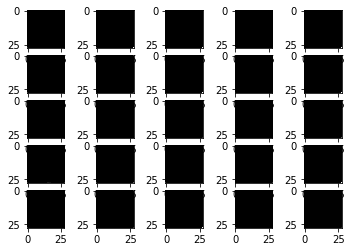

In [112]:
plotGenerated()

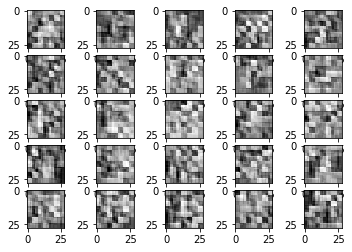

c:\users\sergey\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator:  0.64137113 0.5
generator:  0.64222765 1.0
epoch:  0


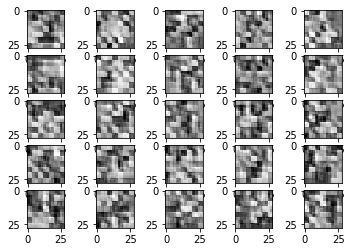

discriminator:  0.6320097 0.5
generator:  0.6423597 1.0
epoch:  1


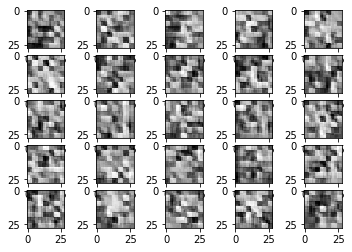

discriminator:  0.6250184 0.5
generator:  0.64071816 1.0
epoch:  2


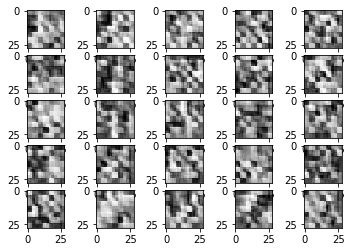

discriminator:  0.618889 0.5
generator:  0.6387712 1.0
epoch:  3


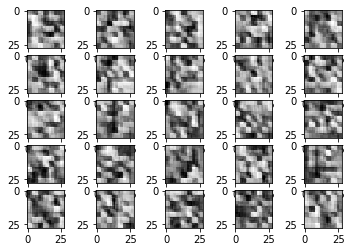

discriminator:  0.6138166 0.5
generator:  0.6324947 1.0
epoch:  4


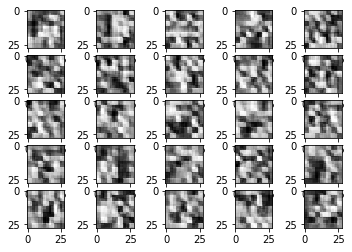

discriminator:  0.61104506 0.5
generator:  0.62245136 1.0
epoch:  5


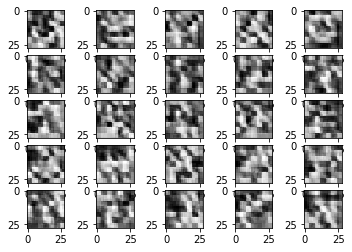

discriminator:  0.61005354 0.5
generator:  0.61090624 1.0
epoch:  6


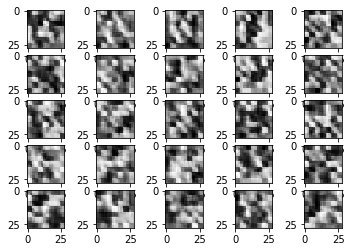

discriminator:  0.6065868 0.5
generator:  0.5950886 1.0
epoch:  7


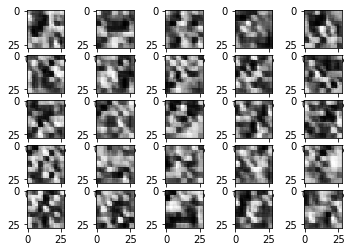

discriminator:  0.6112999 0.5
generator:  0.58491445 1.0
epoch:  8


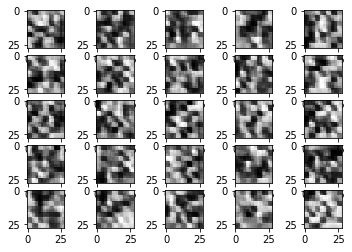

discriminator:  0.61206913 0.5
generator:  0.55711526 1.0
epoch:  9


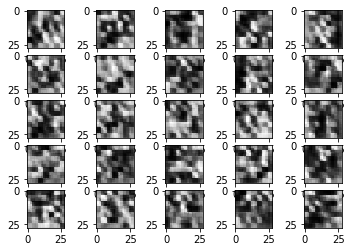

discriminator:  0.62630355 0.5
generator:  0.5232627 1.0
epoch:  10


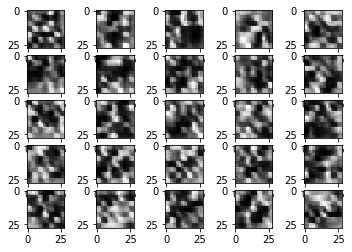

discriminator:  0.63094604 0.5
generator:  0.49916935 1.0
epoch:  11


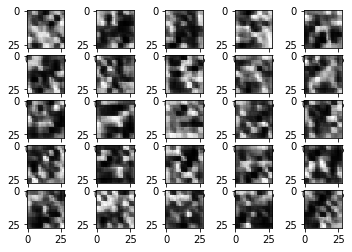

discriminator:  0.65270066 0.5
generator:  0.47786617 1.0
epoch:  12


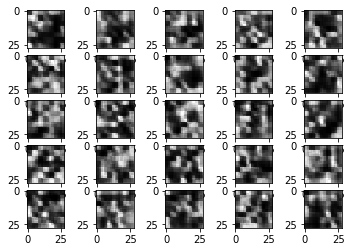

discriminator:  0.6735858 0.5
generator:  0.4520376 1.0
epoch:  13


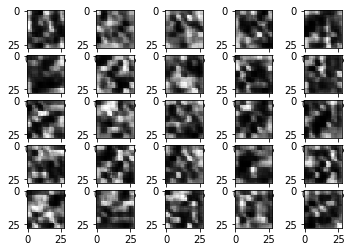

discriminator:  0.6964546 0.5
discriminator:  0.6934894 0.5
discriminator:  0.68990135 0.5
discriminator:  0.6842314 0.5
discriminator:  0.6818706 0.5
discriminator:  0.69211036 0.5
discriminator:  0.67368186 0.5
generator:  0.4594475 1.0
epoch:  14


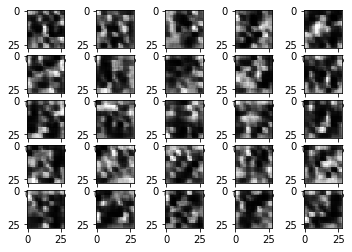

discriminator:  0.6921134 0.5
discriminator:  0.69859535 0.5
discriminator:  0.6898085 0.5
discriminator:  0.68669355 0.5
generator:  0.47200555 1.0
epoch:  15


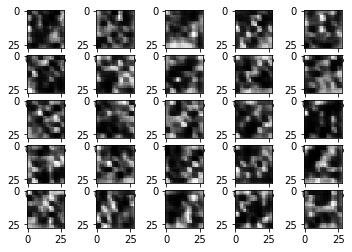

discriminator:  0.6952662 0.5
generator:  0.47044316 1.0
epoch:  16


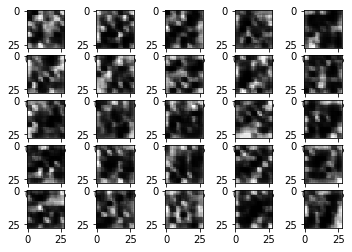

discriminator:  0.7154312 0.5
discriminator:  0.70995396 0.5
discriminator:  0.7032502 0.5
generator:  0.48854145 1.0
epoch:  17


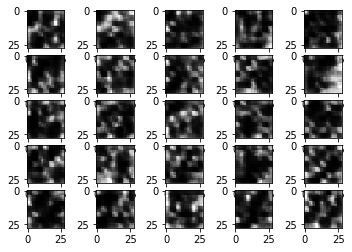

discriminator:  0.71512073 0.5
generator:  0.4920358 1.0
epoch:  18


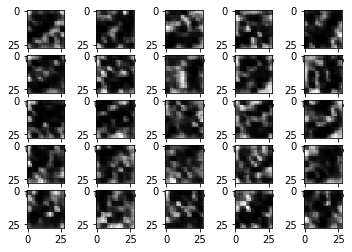

discriminator:  0.7175003 0.5
generator:  0.48580182 1.0
epoch:  19


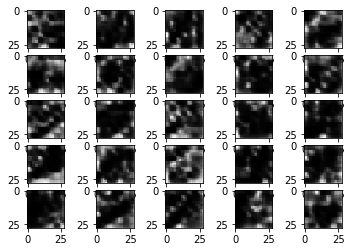

discriminator:  0.7291851 0.5
discriminator:  0.72461426 0.5
generator:  0.503008 1.0
epoch:  20


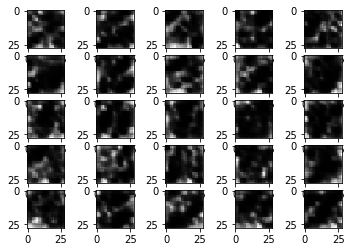

discriminator:  0.72352624 0.5
generator:  0.5101755 1.0
epoch:  21


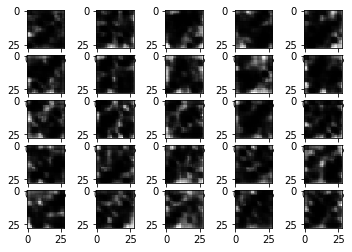

discriminator:  0.7257527 0.5
generator:  0.5148145 1.0
epoch:  22


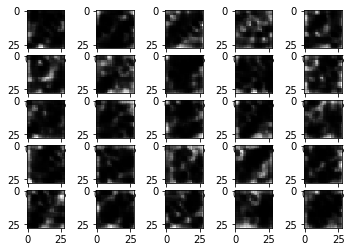

discriminator:  0.7244935 0.5
generator:  0.5251916 1.0
epoch:  23


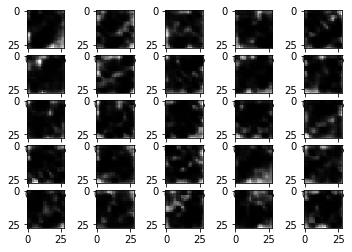

discriminator:  0.7252492 0.5
generator:  0.5367934 1.0
epoch:  24


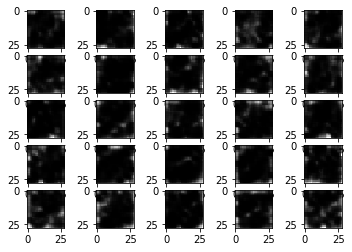

discriminator:  0.7223834 0.5
generator:  0.5515804 1.0
epoch:  25


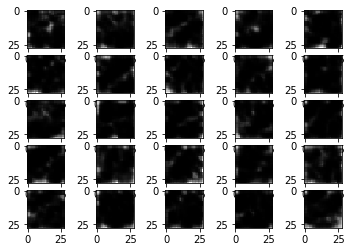

discriminator:  0.71492714 0.5
generator:  0.56665456 1.0
epoch:  26


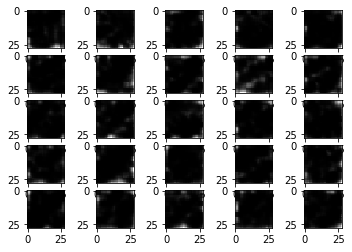

discriminator:  0.7127396 0.5
generator:  0.58448726 1.0
epoch:  27


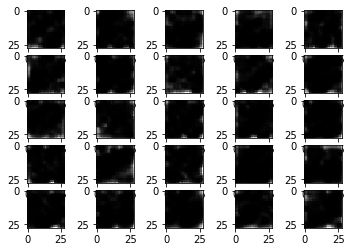

discriminator:  0.70528936 0.5
generator:  0.60342443 1.0
epoch:  28


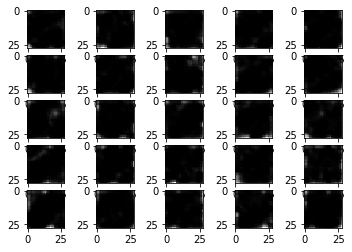

discriminator:  0.7000129 0.5
generator:  0.6238971 1.0
epoch:  29


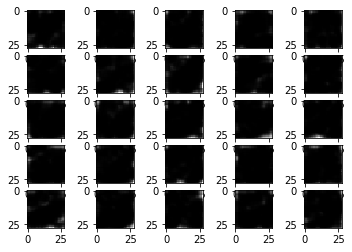

discriminator:  0.6941142 0.5
generator:  0.6441469 1.0
epoch:  30


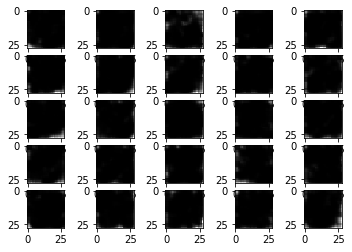

discriminator:  0.6891512 0.5
generator:  0.66350114 1.0
epoch:  31


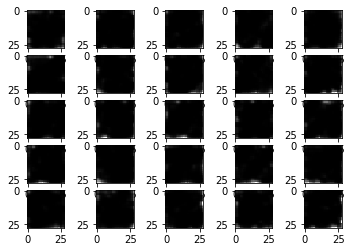

discriminator:  0.6832208 0.5
generator:  0.68243563 1.0
epoch:  32


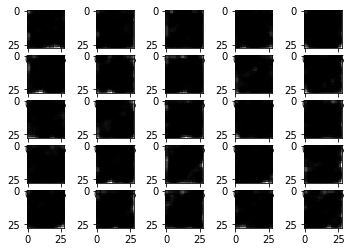

discriminator:  0.6805757 0.5
generator:  0.7010803 0.0
epoch:  33


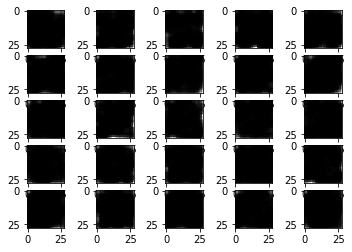

discriminator:  0.67408353 1.0
generator:  0.71928227 0.0
epoch:  34


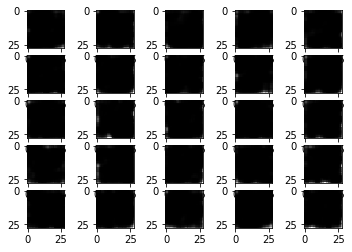

discriminator:  0.67277175 0.921875
generator:  0.7362102 0.0
epoch:  35


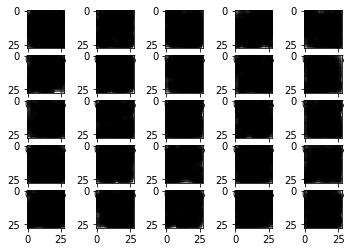

discriminator:  0.6694674 0.78125
generator:  0.75236356 0.0
epoch:  36


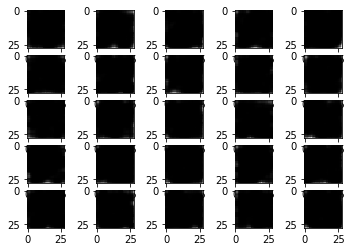

discriminator:  0.66568506 0.703125
generator:  0.7679068 0.0
epoch:  37


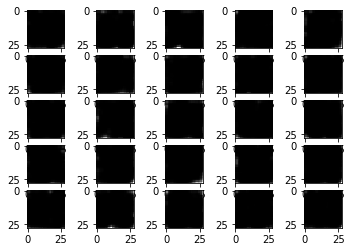

discriminator:  0.66157436 0.640625
generator:  0.78255546 0.0
epoch:  38


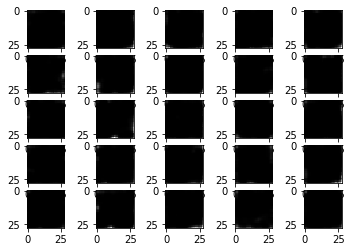

discriminator:  0.6581215 0.640625
generator:  0.7962787 0.0
epoch:  39


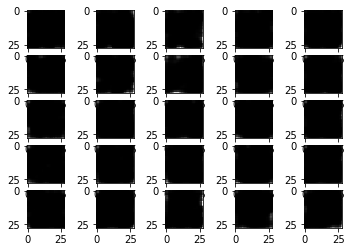

discriminator:  0.65710104 0.546875
generator:  0.8090541 0.0
epoch:  40


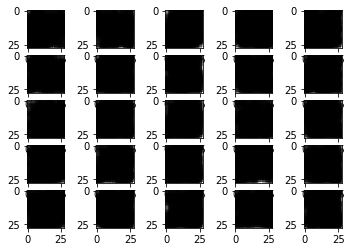

discriminator:  0.65666586 0.59375
generator:  0.8209967 0.0
epoch:  41


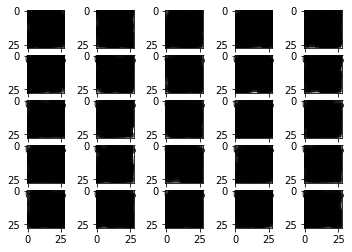

discriminator:  0.6466882 0.640625
generator:  0.8324601 0.0
epoch:  42


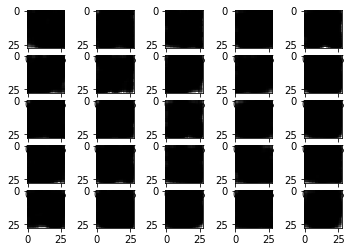

discriminator:  0.64719075 0.59375
generator:  0.84311426 0.0
epoch:  43


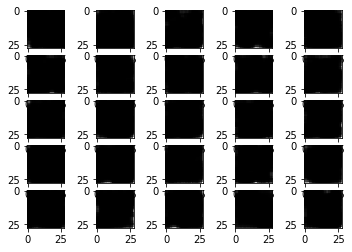

discriminator:  0.64488685 0.546875
generator:  0.8532329 0.0
epoch:  44


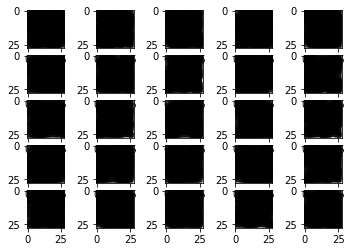

discriminator:  0.64432395 0.5625
generator:  0.8622637 0.0
epoch:  45


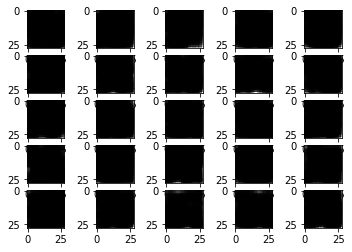

discriminator:  0.6337358 0.625
generator:  0.87056404 0.0
epoch:  46


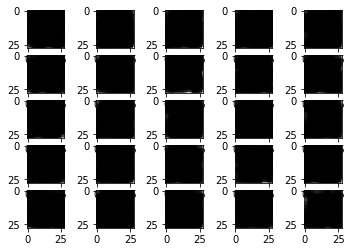

discriminator:  0.62978566 0.671875
generator:  0.877619 0.0
epoch:  47


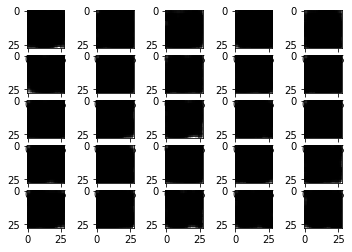

discriminator:  0.6352004 0.59375
generator:  0.8837896 0.0
epoch:  48


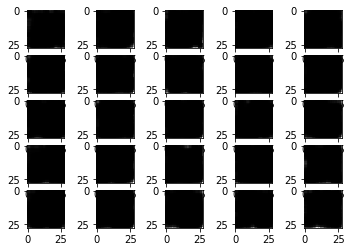

discriminator:  0.62001705 0.6875
generator:  0.89020085 0.0
epoch:  49


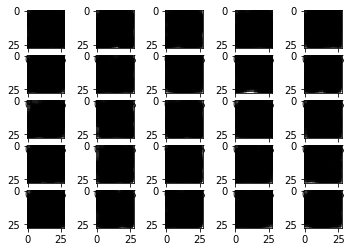

discriminator:  0.6200172 0.703125
generator:  0.8960594 0.0
epoch:  50


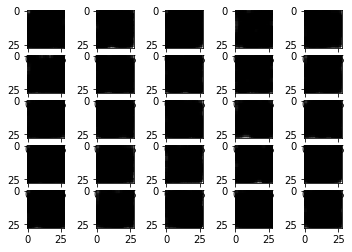

discriminator:  0.6069384 0.8125
generator:  0.90236276 0.0
epoch:  51


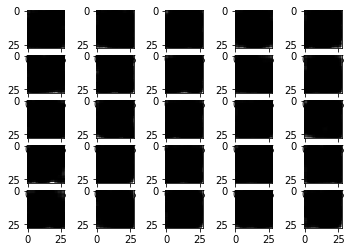

discriminator:  0.60662866 0.703125
generator:  0.90938914 0.0
epoch:  52


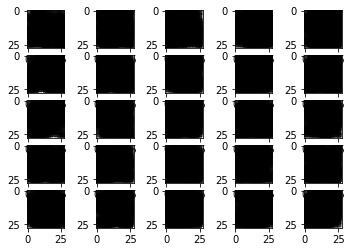

discriminator:  0.60308045 0.734375
generator:  0.9154574 0.0
generator:  0.91551304 0.0
generator:  0.915545 0.0
generator:  0.9155723 0.0
generator:  0.9155556 0.0
generator:  0.9155203 0.0
generator:  0.9155341 0.0
generator:  0.91549146 0.0
generator:  0.9155338 0.0
generator:  0.9155645 0.0
generator:  0.9155385 0.0
generator:  0.9154955 0.0
generator:  0.91547006 0.0
generator:  0.91551375 0.0
generator:  0.9155264 0.0
generator:  0.915483 0.0
generator:  0.9155532 0.0
generator:  0.915576 0.0
generator:  0.9154963 0.0
generator:  0.9155024 0.0
epoch:  53


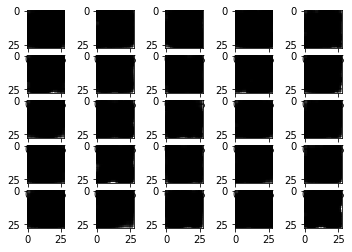

discriminator:  0.5971664 0.828125
generator:  0.9219685 0.0
generator:  0.9220283 0.0
generator:  0.9220173 0.0
generator:  0.92202973 0.0
generator:  0.9219496 0.0
generator:  0.92196727 0.0
generator:  0.921937 0.0
generator:  0.9219336 0.0
generator:  0.9219308 0.0
generator:  0.9219473 0.0
generator:  0.92192 0.0
generator:  0.92195845 0.0
generator:  0.9219103 0.0
generator:  0.9218421 0.0
generator:  0.92186856 0.0
generator:  0.92187023 0.0
generator:  0.9218769 0.0
generator:  0.9219104 0.0
generator:  0.92192113 0.0
generator:  0.92186207 0.0
epoch:  54


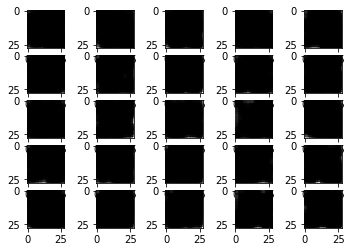

discriminator:  0.58276 0.859375
generator:  0.9288318 0.0
generator:  0.9288412 0.0
generator:  0.9287842 0.0
generator:  0.92879677 0.0
generator:  0.9287805 0.0
generator:  0.92870986 0.0
generator:  0.92870235 0.0
generator:  0.92874336 0.0
generator:  0.9287235 0.0
generator:  0.9286381 0.0
generator:  0.92855275 0.0
generator:  0.9286382 0.0
generator:  0.9285872 0.0
generator:  0.92866665 0.0
generator:  0.928609 0.0
generator:  0.9286189 0.0
generator:  0.92851603 0.0
generator:  0.9285906 0.0
generator:  0.92846453 0.0
generator:  0.9284723 0.0
epoch:  55


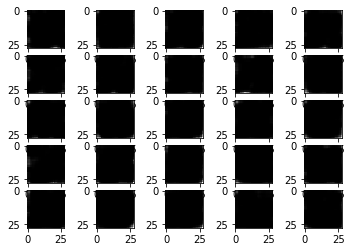

discriminator:  0.57894206 0.875
generator:  0.9348944 0.0
generator:  0.9349148 0.0
generator:  0.93495846 0.0
generator:  0.9347336 0.0
generator:  0.93485355 0.0
generator:  0.9347222 0.0
generator:  0.9346369 0.0
generator:  0.9344791 0.0
generator:  0.9344537 0.0
generator:  0.9344158 0.0
generator:  0.9343577 0.0
generator:  0.9344254 0.0
generator:  0.9343723 0.0
generator:  0.93407553 0.0
generator:  0.9340001 0.0
generator:  0.9340329 0.0
generator:  0.93367547 0.0
generator:  0.93351674 0.0
generator:  0.9333235 0.0
generator:  0.9328083 0.0
epoch:  56


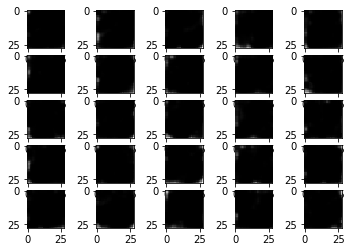

discriminator:  0.5785334 0.828125
generator:  0.9352631 0.0
generator:  0.93442583 0.0
generator:  0.93420243 0.0
generator:  0.9338529 0.0
generator:  0.9329221 0.0
generator:  0.93102586 0.0
generator:  0.9306201 0.0
generator:  0.9291766 0.0
generator:  0.92653275 0.0
generator:  0.9228533 0.0
generator:  0.9179097 0.0
generator:  0.90852165 0.0
generator:  0.8949043 0.0
generator:  0.87147474 0.0
generator:  0.8327311 0.0
epoch:  57


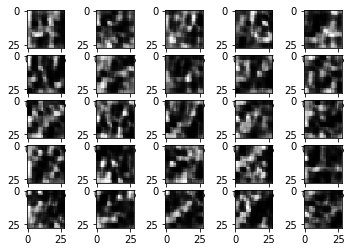

discriminator:  0.61676717 0.90625
generator:  0.78084135 0.0
epoch:  58


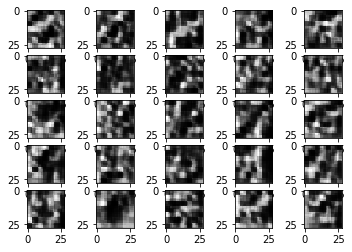

discriminator:  0.6471205 0.796875
generator:  0.7129216 0.25
epoch:  59


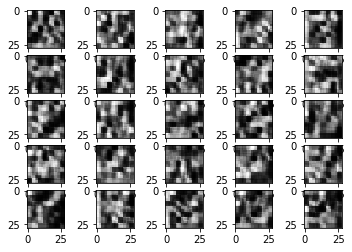

discriminator:  0.6883075 0.4375
generator:  0.6242708 1.0
epoch:  60


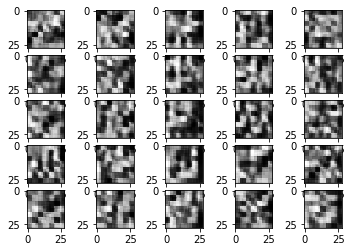

discriminator:  0.7179819 0.4375
generator:  0.56051147 1.0
epoch:  61


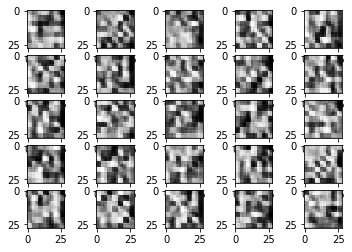

discriminator:  0.7435069 0.46875
generator:  0.5167056 1.0
epoch:  62


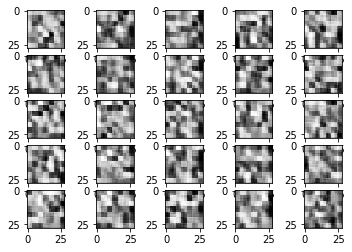

discriminator:  0.77401286 0.453125
generator:  0.48514062 1.0
epoch:  63


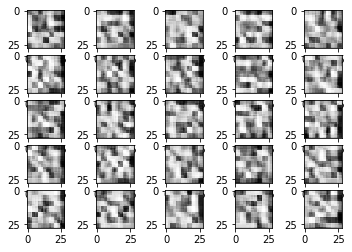

discriminator:  0.7671217 0.5
discriminator:  0.75458395 0.484375
discriminator:  0.73556197 0.5
discriminator:  0.71307975 0.5
generator:  0.51396173 1.0
epoch:  64


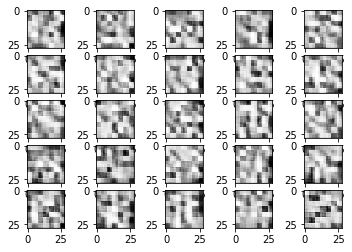

discriminator:  0.68034035 0.5
generator:  0.53154397 1.0
epoch:  65


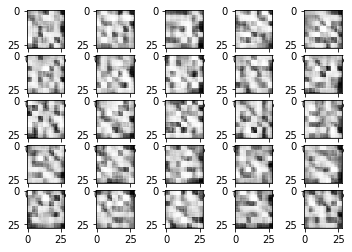

discriminator:  0.66786957 0.5
generator:  0.55710924 1.0
epoch:  66


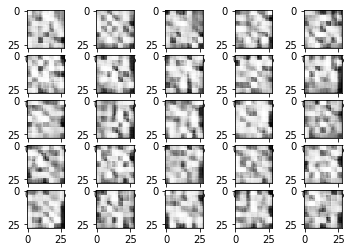

discriminator:  0.6359053 0.5
generator:  0.582216 1.0
epoch:  67


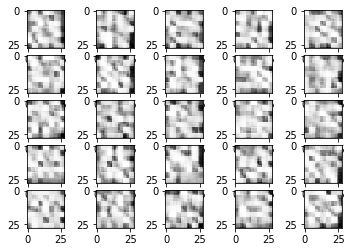

discriminator:  0.6078087 0.5
generator:  0.6153296 1.0
epoch:  68


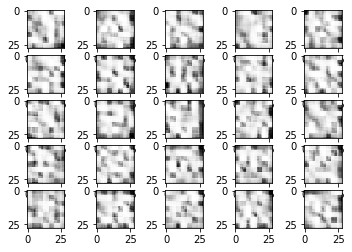

discriminator:  0.57446635 0.5
generator:  0.64590514 1.0
epoch:  69


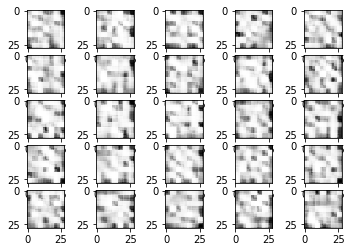

discriminator:  0.5452592 0.5
generator:  0.67867315 0.984375
epoch:  70


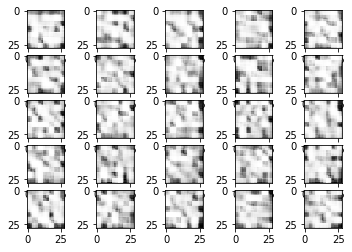

discriminator:  0.5170226 0.5
generator:  0.70558596 0.03125
epoch:  71


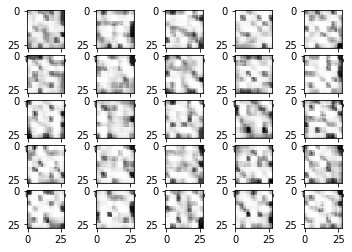

discriminator:  0.49377978 0.96875
generator:  0.72733307 0.0
epoch:  72


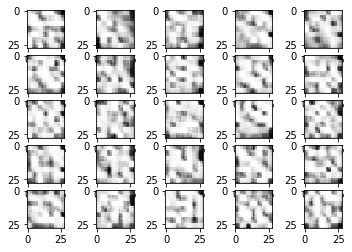

discriminator:  0.47359303 1.0
generator:  0.7427732 0.0
generator:  0.7339244 0.0
generator:  0.7183013 0.0
generator:  0.6951897 0.46875
epoch:  73


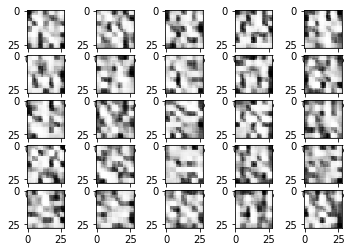

discriminator:  0.4853828 0.578125
generator:  0.6900952 0.546875
epoch:  74


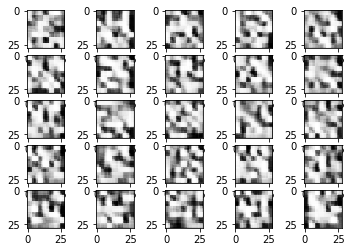

discriminator:  0.4840768 0.515625
generator:  0.6644019 0.859375
epoch:  75


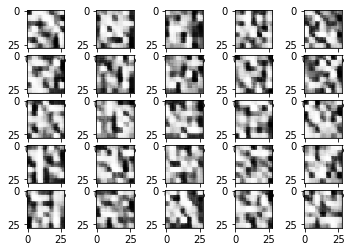

discriminator:  0.49419987 0.515625
generator:  0.6399548 0.921875
epoch:  76


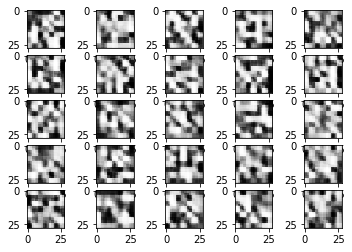

discriminator:  0.5067681 0.5
generator:  0.5980317 0.984375
epoch:  77


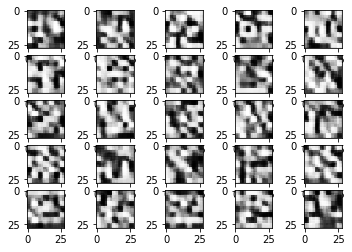

discriminator:  0.5270412 0.5
generator:  0.5569288 1.0
epoch:  78


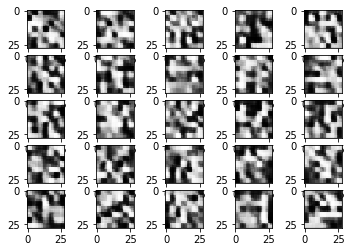

discriminator:  0.5395552 0.5
generator:  0.51299363 1.0
epoch:  79


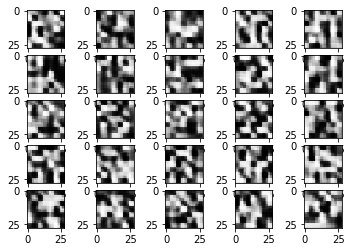

discriminator:  0.5850797 0.5
generator:  0.46849906 1.0
epoch:  80


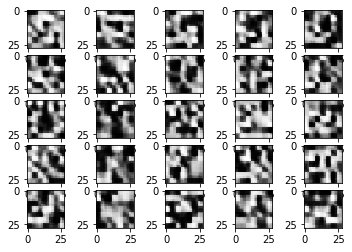

discriminator:  0.60552686 0.5
generator:  0.42273426 1.0
epoch:  81


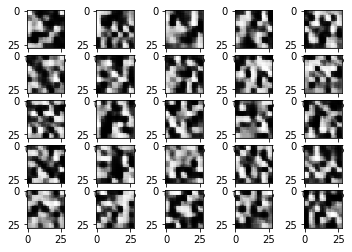

discriminator:  0.6475243 0.5
discriminator:  0.64118516 0.5
discriminator:  0.6299336 0.5
generator:  0.40844688 1.0
epoch:  82


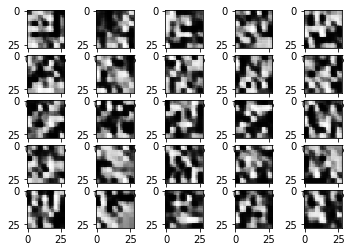

discriminator:  0.6764529 0.5
discriminator:  0.6433477 0.5
discriminator:  0.6433636 0.5
discriminator:  0.63547367 0.5
discriminator:  0.61431247 0.5
discriminator:  0.608467 0.5
generator:  0.4886651 1.0
epoch:  83


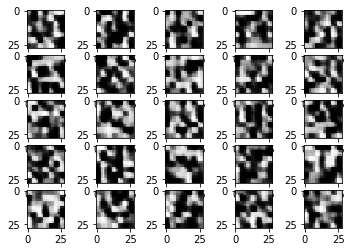

discriminator:  0.611858 0.5
generator:  0.49873754 1.0
epoch:  84


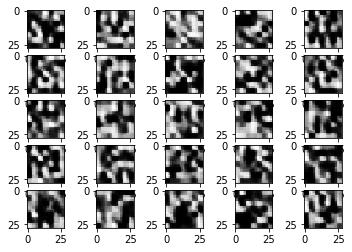

discriminator:  0.6424764 0.5
generator:  0.47303486 1.0
epoch:  85


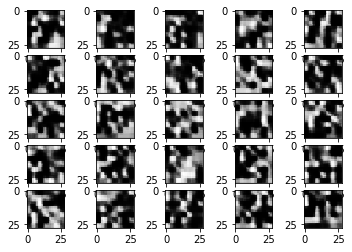

discriminator:  0.6575607 0.5
generator:  0.45895022 0.984375
epoch:  86


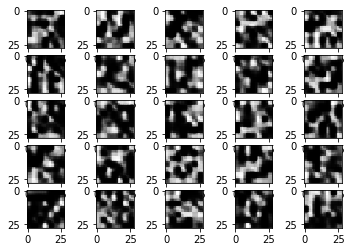

discriminator:  0.7109703 0.5
discriminator:  0.6746989 0.5
generator:  0.47390258 1.0
epoch:  87


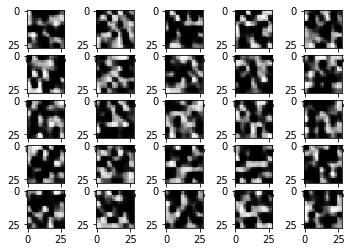

discriminator:  0.69283605 0.5
generator:  0.4737282 1.0
epoch:  88


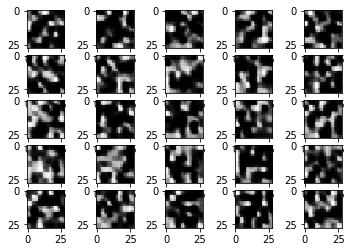

discriminator:  0.7090281 0.5
generator:  0.4694491 1.0
epoch:  89


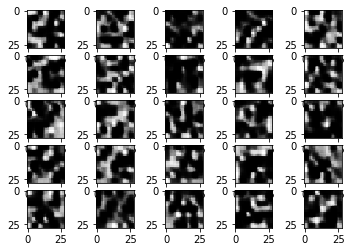

discriminator:  0.7169582 0.5
discriminator:  0.6963929 0.5
generator:  0.5088842 1.0
epoch:  90


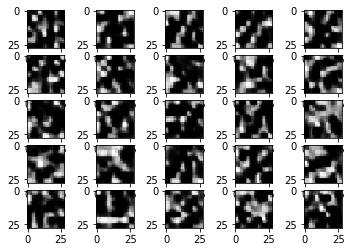

discriminator:  0.7174245 0.5
generator:  0.51303804 1.0
epoch:  91


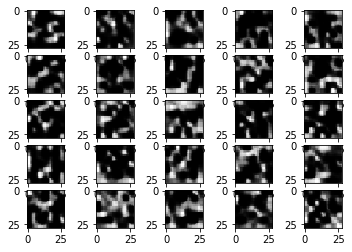

discriminator:  0.74194264 0.5
generator:  0.51710665 1.0
epoch:  92


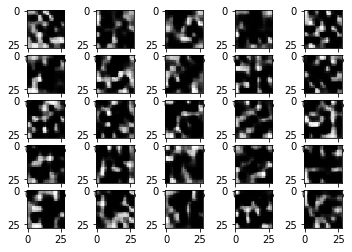

discriminator:  0.73260987 0.5
generator:  0.53061545 1.0
epoch:  93


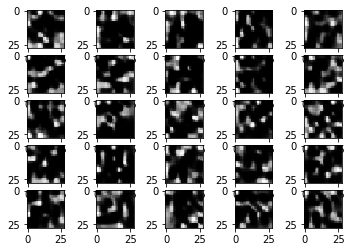

discriminator:  0.73799694 0.5
generator:  0.54766524 1.0
epoch:  94


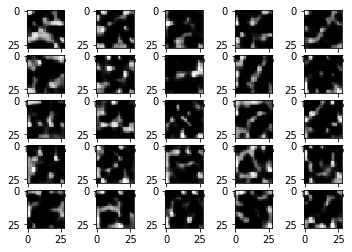

discriminator:  0.73439443 0.453125
generator:  0.5667089 1.0
epoch:  95


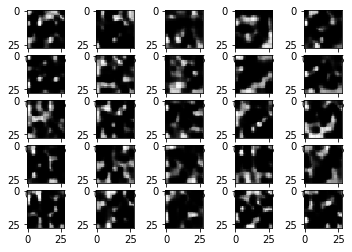

discriminator:  0.7386439 0.453125
generator:  0.5870189 1.0
epoch:  96


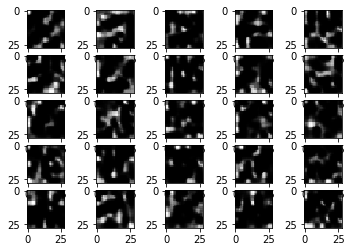

discriminator:  0.7441981 0.328125
generator:  0.614353 1.0
epoch:  97


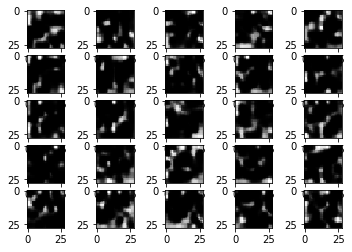

discriminator:  0.7483772 0.234375
generator:  0.64086926 1.0
epoch:  98


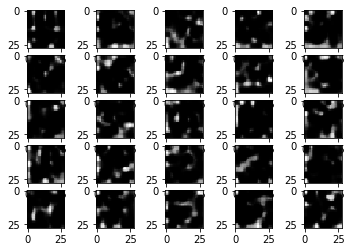

discriminator:  0.7446381 0.09375
generator:  0.67272246 0.984375
epoch:  99


In [116]:
createModel(8, 2, 8)
trainModel(50)